# 妞妞
過年跟親戚打牌學會玩這個遊戲 <br>
希望能先藉由簡單的模擬來增加自己的贏面 <br>
這部分完成後希望能引入機器學習(GAN)之類的方法完善此模型 <br>

# import package

In [1]:
# import package
import itertools
import pandas as pd
import random
from collections import Counter
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft Henge'] 
plt.rcParams['axes.unicode_minus'] = False

# 生成一副撲克牌

In [2]:
# generate deck
def generate_deck():
    # def poker with rank & suit
    suits = ['spade', 'heart', 'diamond', 'club']
    ranks = [str(i) for i in range(2, 11)] + ['J', 'Q', 'K', 'A']
    # generate a poker deck
    return [(suit, rank) for suit in suits for rank in ranks]

# 轉換牌 & 排序大小

## 點數

In [3]:
# get card value
def card_value(card):
    # J, Q, K == 10
    # A == 1
    rank = card[1]
    return 10 if rank in ['J', 'Q', 'K'] else (1 if rank == 'A' else int(rank))

# get card rank
def get_card_rank(card):
    rank_order = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10,
                  'J': 11, 'Q': 12, 'K': 13, 'A': 1}
    return rank_order[card[1]]


## 花色

In [4]:
# get suit rank
def get_suit_rank(card):
    suit_order = {'spade': 4, 'heart': 3, 'diamond': 2, 'club': 1}
    return suit_order[card[0]]

# 計算 5 張牌的牌型

In [5]:
# caculate fix 5 card type
def calculate_niu(cards):
    # compare value rank then suit rank
    cards_value = [card_value(card) for card in cards]

    # sepcial card type
    if all(card[1] in ['J', 'Q', 'K'] for card in cards):
        return '五公'
    if all(v < 5 for v in cards_value) and sum(cards_value) == 10:
        return '五小牛'
    if sum(1 for card in cards if card[1] in ['J', 'Q', 'K']) == 4 and any(card[1] == '10' for card in cards):
        return '四花牛'

    # normal card type
    for combo in itertools.combinations(cards_value, 3):
        if sum(combo) % 10 == 0:
            remaining = [v for v in cards_value if v not in combo][:2]
            if sum(remaining) % 10 == 0:
                return '牛牛'
            else:
                return f'牛{sum(remaining) % 10}'

    # check J, Q, K
    return '有公無牛' if any(card[1] in ['J', 'Q', 'K'] for card in cards) else '無公無牛'


## 確認目前為止是否正確
1. 是否可以得到正確的牌型 <br>
測試出幾乎所有的情況

In [6]:
# hands
hand1 = [('spade', 'A'), ('heart', '2'), ('diamond', '3'), ('club', '2'), ('spade', '2')]
hand2 = [('spade', 'A'), ('heart', '2'), ('diamond', '3'), ('club', '2'), ('spade', '5')]
hand3 = [('spade', 'J'), ('heart', 'Q'), ('diamond', 'K'), ('club', 'J'), ('spade', 'Q')]
hand4 = [('spade', 'J'), ('heart', 'Q'), ('diamond', 'K'), ('club', 'J'), ('spade', '10')]
hand5 = [('spade', 'J'), ('heart', 'Q'), ('diamond', 'A'), ('club', '5'), ('spade', '8')]
hand6 = [('spade', 'A'), ('heart', '2'), ('diamond', '3'), ('club', '8'), ('spade', '3')]
hand7 = [('spade', 'J'), ('heart', 'Q'), ('diamond', '10'), ('club', 'J'), ('spade', '10')]
hand8 = [('spade', 'J'), ('heart', 'Q'), ('diamond', '10'), ('club', 'J'), ('spade', '9')]
hand9 = [('spade', 'J'), ('heart', 'Q'), ('diamond', '10'), ('club', 'J'), ('spade', '8')]
hand10 = [('spade', 'J'), ('heart', 'Q'), ('diamond', '10'), ('club', 'J'), ('spade', '7')]
hand11 = [('spade', 'J'), ('heart', 'Q'), ('diamond', '10'), ('club', 'J'), ('spade', '5')]

# result
print(calculate_niu(hand1))
print(calculate_niu(hand2))
print(calculate_niu(hand3))
print(calculate_niu(hand4))
print(calculate_niu(hand5))
print(calculate_niu(hand6))
print(calculate_niu(hand7))
print(calculate_niu(hand8))
print(calculate_niu(hand9))
print(calculate_niu(hand10))
print(calculate_niu(hand11))


五小牛
牛1
五公
四花牛
有公無牛
無公無牛
牛牛
牛9
牛8
牛7
牛5


# 模擬牌型出現機率

In [7]:
# def simulate card type rate
def simulate_cardtype_rate(hand, num_simulations=500000):
    # generate poker deck
    deck = generate_deck()

    # remove cards already in hand
    for card in hand:
        deck.remove(card)

    results = Counter()
    for _ in range(num_simulations):
        # random choose a card
        remaining_card = random.choice(deck)
        final_hand = hand + [remaining_card]
        # only want to know card type
        card_type = calculate_niu(final_hand)
        results[card_type] += 1

    total = sum(results.values())
    probabilities = {k: v / total for k, v in results.items()}
    sorted_probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
    return sorted_probabilities


## 確認機率情況

In [8]:
hand1 = [('spade', 'J'), ('heart', 'Q'), ('diamond', 'K'), ('club', 'A')]
simulate_cardtype_rate(hand1)

{'牛1': 0.27108,
 '牛4': 0.083906,
 '牛牛': 0.083602,
 '牛3': 0.083318,
 '牛5': 0.083098,
 '牛6': 0.08295,
 '牛8': 0.082878,
 '牛9': 0.082854,
 '牛7': 0.0828,
 '牛2': 0.063514}

# 如果牌型一樣時會需要比較最高張
比較手牌最高張

In [9]:
# only compare the highest card
# return who win
def compare_highest_card(player_hand, banker_hand):
    player_hand_sorted = sorted(player_hand, key=lambda x: (get_card_rank(x), get_suit_rank(x)), reverse=True)
    banker_hand_sorted = sorted(banker_hand, key=lambda x: (get_card_rank(x), get_suit_rank(x)), reverse=True)
    
    player_max_card = player_hand_sorted[0]
    banker_max_card = banker_hand_sorted[0]

    if get_card_rank(player_max_card) > get_card_rank(banker_max_card):
        return "player"
    elif get_card_rank(player_max_card) < get_card_rank(banker_max_card):
        return "banker"
    else:
        if get_suit_rank(player_max_card) > get_suit_rank(banker_max_card):
            return "player"
        else:
            return "banker"

# 結算金額

In [10]:
# caculate payout
def calculate_payout(player_hand, banker_hand, verbose=True, debug = True):
    # debug of same card
    if debug:
        if len(set(player_hand)) != len(player_hand):
            return "錯誤：玩家手牌有重複的牌！" if verbose else None
        if len(set(banker_hand)) != len(banker_hand):
            return "錯誤：莊家手牌有重複的牌！" if verbose else None
        combined_hand = player_hand + banker_hand
        if len(set(combined_hand)) != len(combined_hand):
            return "錯誤：玩家與莊家有相同的牌！" if verbose else None


    # def hand's rank
    rank_order = {
        '五小牛': 15, '五公': 14, '四花牛': 13, '牛牛': 12, '牛9': 11, '牛8': 10,
        '牛7': 9, '牛6': 8, '牛5': 7, '牛4': 6, '牛3': 5, '牛2': 4, '牛1': 3,
        '有公無牛': 2, '無公無牛': 1
    }

    # def payout of hand
    rank_mult = {
        '五小牛': 6, '五公': 5, '四花牛': 4, '牛牛': 3, '牛9': 2, '牛8': 2,
        '牛7': 2, '牛6': 1, '牛5': 1, '牛4': 1, '牛3': 1, '牛2': 1, '牛1': 1,
        '有公無牛': 1, '無公無牛': 2
    }

    # get player & banker hand
    player_type = calculate_niu(player_hand)
    banker_type = calculate_niu(banker_hand)

    player_rank = rank_order[player_type]
    banker_rank = rank_order[banker_type]
    player_mult = rank_mult[player_type]
    banker_mult = rank_mult[banker_type]

    # compare hand rank
    if player_rank > banker_rank:
        multiplier = player_mult if banker_type != '無公無牛' else player_mult * 2
        return f"玩家贏，賠率為 {multiplier} 倍" if verbose else multiplier
    elif player_rank < banker_rank:
        multiplier = -banker_mult if player_type != '無公無牛' else -banker_mult * 2
        return f"玩家輸，賠率為 {multiplier} 倍" if verbose else multiplier

    # if same hand, compare max card
    player_max_card = max(player_hand, key=lambda x: (get_card_rank(x), get_suit_rank(x)))
    banker_max_card = max(banker_hand, key=lambda x: (get_card_rank(x), get_suit_rank(x)))

    if get_card_rank(player_max_card) > get_card_rank(banker_max_card):
        return f"玩家贏，賠率為 {player_mult} 倍" if verbose else player_mult
    elif get_card_rank(player_max_card) < get_card_rank(banker_max_card):
        return f"玩家輸，賠率為 {-banker_mult} 倍" if verbose else -banker_mult

    # if same card num, compare suit rank
    if get_suit_rank(player_max_card) > get_suit_rank(banker_max_card):
        return f"玩家贏，賠率為 {player_mult} 倍" if verbose else player_mult
    else:
        return f"玩家輸，賠率為 {-banker_mult} 倍" if verbose else -banker_mult


## 確認其中的一些情況

In [11]:
# banker wins
## normal
player_hand = [('heart', '9'), ('diamond', 'J'), ('club', '3'), ('spade', '6'), ('heart', '2')]
banker_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('diamond', '2')]
print(calculate_payout(player_hand, banker_hand))

## banker have double
player_hand = [('heart', '9'), ('diamond', 'J'), ('club', '3'), ('spade', '6'), ('heart', '2')]
banker_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('diamond', '7')]
print(calculate_payout(player_hand, banker_hand))

## banker have niuniu
player_hand = [('heart', '9'), ('diamond', 'J'), ('club', '3'), ('spade', '6'), ('heart', '2')]
banker_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('diamond', '4')]
print(calculate_payout(player_hand, banker_hand))

## player have nothing
player_hand = [('heart', '9'), ('diamond', '3'), ('club', '3'), ('spade', '6'), ('heart', '2')]
banker_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('diamond', '7')]
print(calculate_payout(player_hand, banker_hand))

# banker wins
## normal
player_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('diamond', '2')]
banker_hand = [('heart', '9'), ('diamond', 'J'), ('club', '3'), ('spade', '6'), ('heart', '2')]
print(calculate_payout(player_hand, banker_hand))

# error
# for player have same card, raise error
player_hand = [('heart', '9'), ('diamond', 'J'), ('club', '3'), ('spade', '6'), ('heart', '9')]
print(calculate_payout(player_hand, banker_hand))

# for banker have same card, raise error
banker_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('spade', '10')]
print(calculate_payout(player_hand, banker_hand))

# for banker & player have same card, raise error
player_hand = [('heart', '9'), ('diamond', 'J'), ('club', '3'), ('spade', '6'), ('heart', '2')]
banker_hand = [('spade', '10'), ('club', 'J'), ('heart', '4'), ('diamond', '6'), ('heart', '9')]
print(calculate_payout(player_hand, banker_hand))


玩家輸，賠率為 -1 倍
玩家輸，賠率為 -2 倍
玩家輸，賠率為 -3 倍
玩家輸，賠率為 -4 倍
玩家贏，賠率為 1 倍
錯誤：玩家手牌有重複的牌！
錯誤：玩家手牌有重複的牌！
錯誤：玩家與莊家有相同的牌！


# 總結目前有的函式

1. `simulate_cardtype_rate(hand, num_simulations=500000)` : <br>
給定 4 張牌會返回組成不同牌型的機率 <br>


2. `calculate_payout(player_hand, banker_hand)` : <br>
給定莊家以及玩家的手牌 <br>
返回誰獲勝以及得到的賠率 <br>

# 希望得到完全隨機的情況下不同牌型的機率

In [12]:
# simulate card type probability
def simulate_cardtype_probability(num_simulations=1000000):
    # generate deck
    deck = generate_deck()
    results = Counter()

    for _ in range(num_simulations):
        # random take 5 card
        hand = random.sample(deck, 5)
        # caculate niu
        card_type = calculate_niu(hand)
        results[card_type] += 1

    # probability
    total = sum(results.values())
    probabilities = {k: v / total for k, v in results.items()}
    
    # sort
    sorted_probabilities = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_probabilities

In [13]:
# simulate
probabilities = simulate_cardtype_probability(5000000)

# print result
for card_type, prob in probabilities.items():
    print(f"{card_type}: {prob:.6%}")


有公無牛: 25.374020%
牛牛: 9.693040%
無公無牛: 8.162600%
牛5: 6.654720%
牛8: 6.261440%
牛7: 6.257740%
牛9: 6.256660%
牛3: 6.255340%
牛1: 6.254920%
牛2: 6.247520%
牛4: 6.231040%
牛6: 6.228980%
四花牛: 0.075420%
五公: 0.031060%
五小牛: 0.015500%


# 進行預估(單純自己手牌)
只預測是否下大注

## 先確認是否搶莊家

In [14]:
# def how to choose the multiple
def simulate_ev(player_hand, num_simulations=500000):
    # generate deck
    deck = generate_deck()
    # remove player's card
    for card in player_hand:
        deck.remove(card)

    # save the result payout(bet 1 a time)
    result_payout = {multiplier: [] for multiplier in range(1, 5)}

    # get every probability of hand type
    # simulate the multiplier from 1~4
    for multiplier in range(1, 5):
        for _ in range(num_simulations // 4):
            remaining_deck = deck.copy()
            # random choose a card
            r_choose_card = random.choice(remaining_deck)
            final_player_hand = player_hand + [r_choose_card]

            # remove the card we get
            remaining_deck.remove(r_choose_card)

            # enemy's hand is random
            enemy_1_hand = random.sample(remaining_deck, 5)
            for card in enemy_1_hand:
                remaining_deck.remove(card)
            enemy_2_hand = random.sample(remaining_deck, 5)
            for card in enemy_2_hand:
                remaining_deck.remove(card)
            enemy_3_hand = random.sample(remaining_deck, 5)
            for card in enemy_3_hand:
                remaining_deck.remove(card)

            # count payout(bet 1 a time)
            battle_1_payout = calculate_payout(final_player_hand, enemy_1_hand, verbose=False)
            battle_2_payout = calculate_payout(final_player_hand, enemy_2_hand, verbose=False)
            battle_3_payout = calculate_payout(final_player_hand, enemy_3_hand, verbose=False)
            total_payout = battle_1_payout + battle_2_payout + battle_3_payout
            # weighted payout
            result_payout[multiplier].append(total_payout * multiplier)

    # get mean EV
    ev_results = {multiplier: sum(payouts) / len(payouts) for multiplier, payouts in result_payout.items()}

    # get best EV
    best_multiplier = max(ev_results, key=ev_results.get)

    return best_multiplier, ev_results


### 可以設定賠率(進行驗證)

In [15]:
# def getting the result with different multiple
def simulate_ev_with_multipliers(player_hand, multipliers=[1], num_simulations=500000):
    # generate deck
    deck = generate_deck()
    # remove player's card
    for card in player_hand:
        deck.remove(card)

    # save the result payout(bet 1 a time)
    result_payouts = []

    # simulate evey multiplier
    for multiplier in multipliers:
        for _ in range(num_simulations // len(multipliers)):
            remaining_deck = deck.copy()
            # random choose a card
            r_choose_card = random.choice(remaining_deck)
            final_player_hand = player_hand + [r_choose_card]

            # remove the card we get
            remaining_deck.remove(r_choose_card)

            # enemy's hand is random
            enemy_1_hand = random.sample(remaining_deck, 5)
            for card in enemy_1_hand:
                remaining_deck.remove(card)
            enemy_2_hand = random.sample(remaining_deck, 5)
            for card in enemy_2_hand:
                remaining_deck.remove(card)
            enemy_3_hand = random.sample(remaining_deck, 5)
            for card in enemy_3_hand:
                remaining_deck.remove(card)

            # count payout(bet 1 a time)
            battle_1_payout = calculate_payout(final_player_hand, enemy_1_hand, verbose=False)
            battle_2_payout = calculate_payout(final_player_hand, enemy_2_hand, verbose=False)
            battle_3_payout = calculate_payout(final_player_hand, enemy_3_hand, verbose=False)
            total_payout = battle_1_payout + battle_2_payout + battle_3_payout
            # weighted payout
            result_payouts.append(total_payout * multiplier)

    return result_payouts

# 實際操作

In [16]:
# 滿手爛牌
player_hand = [('heart', '9'), ('diamond', '3'), ('club', '3'), ('spade', '6')]
best_multiplier, ev_results = simulate_ev(player_hand)
print(f"最佳倍率: {best_multiplier}")
print(f"各倍率的 EV: {ev_results}")

最佳倍率: 1
各倍率的 EV: {1: -3.667288, 2: -7.390048, 3: -11.0562, 4: -14.763968}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft Henge
c:\Users\ACER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 23383 (\N{CJK UNIFIED IDEOGRAPH-5B57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\ACER\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\U

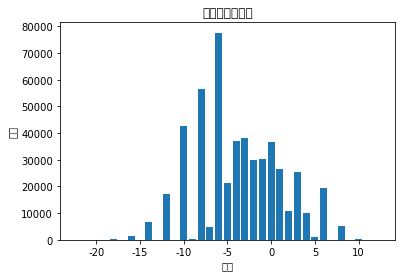

In [17]:
# test
player_hand = [('heart', '9'), ('diamond', '3'), ('club', '3'), ('spade', '6')]
multipliers = [1]

ev_all = simulate_ev_with_multipliers(player_hand, multipliers)
count = Counter(ev_all)

# get frequency
numbers = list(count.keys())
frequencies = list(count.values())

# bar plot
plt.bar(numbers, frequencies)
plt.xlabel('數字')
plt.ylabel('頻率')
plt.title('數字頻率柱狀圖')
plt.show()
